# Text Mining -  Group Project

---

# Preparing the Data

In [2]:
import gensim
import nltk
import timeit
import numpy as np
import pandas as pd
import random
import re
import string
import umap

from sklearn.utils import shuffle
from nltk.tokenize import regexp_tokenize
from sklearn.model_selection import train_test_split

In [3]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dasha\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\dasha\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\dasha\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

## Loading the Data

### Reddit News

In [8]:
import os
os.getcwd()
os.chdir("C:\\Users\\dasha")

In [9]:
reddit_path = "data/reddit_worldnews.csv"
reddit_file = pd.read_csv(reddit_path, encoding="utf-8", encoding_errors="ignore")
print("reddit_file_clmns:", reddit_file.columns)
reddit = pd.DataFrame(reddit_file["title"]).rename(columns={"title":"Headline"})
reddit.head()

reddit_file_clmns: Index(['time_created', 'date_created', 'up_votes', 'down_votes', 'title',
       'over_18', 'author', 'subreddit'],
      dtype='object')


,Headline
0,Scores killed in Pakistan clashes
1,Japan resumes refuelling mission
2,US presses Egypt on Gaza border
3,Jump-start economy: Give health care to all
4,Council of Europe bashes EU&UN terror blacklist


### Ireland News

In [10]:
ireland_path = "data/ireland-news-headlines.csv"
ireland_file = pd.read_csv(ireland_path, encoding="utf-8", encoding_errors="ignore")
print("ireland_file_clmns:", ireland_file.columns)
ireland_filtered_date = ireland_file[(ireland_file["publish_date"] >= 20080125) & 
                                     (ireland_file["publish_date"] <= 20161122)]
ireland = pd.DataFrame(ireland_filtered_date["headline_text"]).rename(columns={"headline_text":"Headline"})
ireland.head()

ireland_file_clmns: Index(['publish_date', 'headline_category', 'headline_text'], dtype='object')


,Headline
747865,Egypt moves to close Gaza border breach
747866,Almost two-thirds of voters undecided on EU tr...
747867,Jacob Fruitfield factory to lay off 220 staff
747868,Bono says rich world failing anti-poverty camp...
747869,Government; NRA announce €1.68bn roads plan


In [16]:
type(ireland_file)

pandas.core.frame.DataFrame

## Preprocessing

In [11]:
# Pre-processing 
# Regular expression used for tokenization
pattern = r'''(?x)    
(?:[A-Z]\.)+          
|\w+(?:-\w+)*         
|\$?\d+(?:\.\d+)?%?   
|\.\.\.               
|[][.,;"\'?():-_`]  
'''

# Lemmatizer used 
lemmatizer = nltk.WordNetLemmatizer()

def preprocessing(df):
    """Input: dataframe
       Output: preprocessed dataframe"""
    
    # Get the stopwords and punctuation
    stopwords = nltk.corpus.stopwords.words('english')
    punct = list(string.punctuation)
    
    # Initialize tokenized list of headlines
    # Get list of headlines
    headlns_lst = df["Headline"].to_list()
    
    tokenized_lines = []
    for headln in headlns_lst:
        line = str(headln).strip().lower()
        line = regexp_tokenize(line, pattern)
        line = [tok for tok in line if tok not in stopwords and tok not in punct and tok.isalpha() and len(tok)>2]
        tokenized_lines.append(line)
    
    # Initialize lemmatized list of headlines
    pp_df = pd.DataFrame(columns = ["Headline"])
    lemmatized_lines = [[lemmatizer.lemmatize(token) for token in headln] for headln in tokenized_lines]
    line_df = pd.DataFrame({"Headline": lemmatized_lines})
    pp_df = pp_df.append(line_df, ignore_index=True)

    return pp_df

### Reddit News

In [22]:
reddit_pp = preprocessing(reddit)
reddit_pp
t = timeit.timeit(lambda:reddit_pp)
print(t)
print(reddit_pp)

0.05376999999862164
                                                 Headline
0                        [score, killed, pakistan, clash]
1                    [japan, resume, refuelling, mission]
2                            [press, egypt, gaza, border]
3                           [economy, give, health, care]
4              [council, europe, bash, terror, blacklist]
...                                                   ...
509231  [heil, trump, donald, trump, white, nationalis...
509232    [people, speculating, could, madeleine, mccann]
509233     [professor, receives, arab, researcher, award]
509234  [nigel, farage, attack, response, trump, ambas...
509235  [palestinian, wielding, knife, shot, dead, wes...

[509236 rows x 1 columns]


C:\Users\dasha\AppData\Local\Temp\ipykernel_30792\351899760.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pp_df = pp_df.append(line_df, ignore_index=True)


### Ireland News

In [12]:
ireland_pp = preprocessing(ireland)
ireland_pp

C:\Users\dasha\AppData\Local\Temp\ipykernel_30792\351899760.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pp_df = pp_df.append(line_df, ignore_index=True)


,Headline
0,"[egypt, move, close, gaza, border, breach]"
1,"[almost, voter, undecided, treaty]"
2,"[jacob, fruitfield, factory, lay, staff]"
3,"[bono, say, rich, world, failing, campaign]"
4,"[government, nra, announce, road, plan]"
...,...
598832,"[vincent, kompany, suffers, injury, eight, yea..."
598833,"[baby, needed, resuscitation, birth, inquiry, ..."
598834,"[spur, whimper, bright, light, monaco]"
598835,"[leicester, continue, contrasting, form, toppi..."


## Latent Dirichlet Analysis
Gensim Implementation

## Reddit

In [23]:
#Exploring vocabulary size
all_words = [word for tokens in reddit_pp['Headline'] for word in tokens]
headline_lengths = [len(tokens) for tokens in reddit_pp['Headline']]

vocab = sorted(list(set(all_words)))

print('{} words total, with a vocabulary size of {}'.format(len(all_words), len(vocab)))
print('Max headline length is {}'.format(max(headline_lengths)))

4816959 words total, with a vocabulary size of 73363
Max headline length is 38


In [24]:
#Dictionary representation. Each word in the headline corpus a unique integer identifier.
reddit_dict = gensim.corpora.Dictionary(reddit_pp.Headline)
#view integer mappings
reddit_dict.token2id

{'clash': 0,
 'killed': 1,
 'pakistan': 2,
 'score': 3,
 'japan': 4,
 'mission': 5,
 'refuelling': 6,
 'resume': 7,
 'border': 8,
 'egypt': 9,
 'gaza': 10,
 'press': 11,
 'care': 12,
 'economy': 13,
 'give': 14,
 'health': 15,
 'bash': 16,
 'blacklist': 17,
 'council': 18,
 'europe': 19,
 'terror': 20,
 'bale': 21,
 'behind': 22,
 'castle': 23,
 'farmer': 24,
 'hay': 25,
 'hide': 26,
 'illegal': 27,
 'presto': 28,
 'tried': 29,
 'unveils': 30,
 'gridlock': 31,
 'protest': 32,
 'strike': 33,
 'mismanagement': 34,
 'program': 35,
 'nicolas': 36,
 'ryanair': 37,
 'sarkozy': 38,
 'sue': 39,
 'threatens': 40,
 'met': 41,
 'missile': 42,
 'plan': 43,
 'polish': 44,
 'resistance': 45,
 'shield': 46,
 'town': 47,
 'video': 48,
 'archbishop': 49,
 'call': 50,
 'canterbury': 51,
 'cruel': 52,
 'law': 53,
 'new': 54,
 'online': 55,
 'punish': 56,
 'thoughtless': 57,
 'time': 58,
 'word': 59,
 'cleansing': 60,
 'envoy': 61,
 'ethnic': 62,
 'kenya': 63,
 'top': 64,
 'violence': 65,
 'building': 66,

In [25]:
#Filtering
reddit_dict.filter_extremes(no_below=10, no_above=0.5)
print('Filtered size of vocabulary:', len(reddit_dict))

#Manually filtering out the word 'say' and its variations
del_ids = [k for k,v in reddit_dict.items() if v=='say']
reddit_dict.filter_tokens(bad_ids=del_ids)

del_ids = [k for k,v in reddit_dict.items() if v=='said']
reddit_dict.filter_tokens(bad_ids=del_ids)

del_ids = [k for k,v in reddit_dict.items() if v=='saying']
reddit_dict.filter_tokens(bad_ids=del_ids)

print('Final filtered size of vocabulary:', len(reddit_dict))

Filtered size of vocabulary: 18676
Final filtered size of vocabulary: 18673


In [26]:
#Bag of Words - counts how many times a word token occurs within a headline
#Output contains a vector for each headline, in the form of (word id, frequency of word occurrence in a headline).

reddit_BOW = [reddit_dict.doc2bow(headline) for headline in reddit_pp['Headline']]

In [59]:
#LDA 
#For the final model, I’ve fit a model with 10 topics and 10 passes.

from gensim.models.ldamodel import LdaModel

k = 10
reddit_lda = LdaModel(reddit_BOW,
                      num_topics = k,
                      id2word = reddit_dict,
                      random_state = 1,
                      passes=10)

reddit_lda.show_topics()

[(0,
  '0.043*"russia" + 0.018*"china" + 0.018*"japan" + 0.017*"deal" + 0.017*"brexit" + 0.016*"russian" + 0.013*"vote" + 0.013*"president" + 0.012*"election" + 0.011*"germany"'),
 (1,
  '0.042*"attack" + 0.033*"killed" + 0.021*"kill" + 0.019*"pakistan" + 0.015*"air" + 0.013*"strike" + 0.012*"bomb" + 0.012*"least" + 0.012*"iraqi" + 0.012*"army"'),
 (2,
  '0.043*"isi" + 0.025*"iran" + 0.022*"mosul" + 0.019*"nuclear" + 0.014*"power" + 0.012*"state" + 0.011*"rio" + 0.011*"scientist" + 0.009*"may" + 0.009*"fight"'),
 (3,
  '0.050*"syria" + 0.032*"minister" + 0.029*"syrian" + 0.027*"turkey" + 0.021*"israel" + 0.019*"state" + 0.017*"indian" + 0.014*"israeli" + 0.013*"obama" + 0.013*"palestinian"'),
 (4,
  '0.021*"philippine" + 0.020*"sea" + 0.016*"court" + 0.015*"found" + 0.014*"duterte" + 0.012*"global" + 0.010*"chinese" + 0.010*"crisis" + 0.010*"year" + 0.009*"island"'),
 (5,
  '0.020*"death" + 0.017*"year" + 0.016*"turkish" + 0.012*"turkey" + 0.012*"child" + 0.011*"man" + 0.010*"arrested"

## PyLDAvis
A library is a great way to visualize topics from a topic model.

I AM SORRY I SEEM TO HAVE LOST THE PYLDAvis graphs... I did manage to use them for topic labelling. 

In [27]:
import pyLDAvis.gensim_models

pyLDAvis.enable_notebook()

vis = pyLDAvis.gensim_models.prepare(reddit_lda, reddit_BOW, dictionary = reddit_lda.id2word)
vis

NameError: name 'reddit_lda' is not defined

## Word Cloud

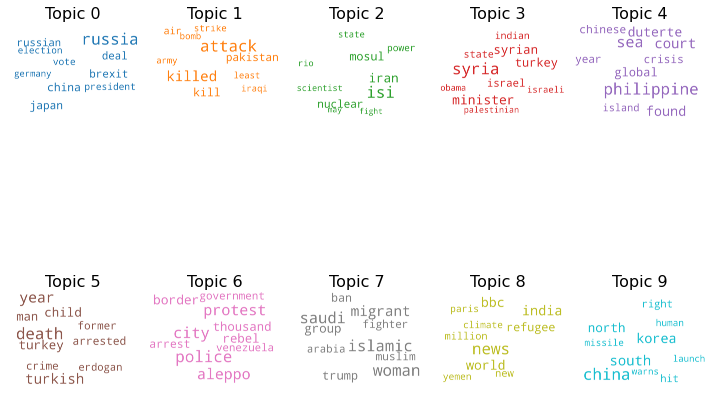

In [62]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = reddit_lda.show_topics(formatted=False)

fig, axes = plt.subplots(2, 5, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

---

## Ireland

In [13]:
#Exploring vocabulary size
all_words = [word for tokens in ireland_pp['Headline'] for word in tokens]
headline_lengths = [len(tokens) for tokens in ireland_pp['Headline']]

vocab = sorted(list(set(all_words)))

print('{} words total, with a vocabulary size of {}'.format(len(all_words), len(vocab)))
print('Max headline length is {}'.format(max(headline_lengths)))

3034305 words total, with a vocabulary size of 66374
Max headline length is 26


In [14]:
#Dictionary representation. Each word in the tweet corpus a unique integer identifier.
ireland_dict = gensim.corpora.Dictionary(ireland_pp.Headline)

#View integer mappings
ireland_dict.token2id

{'border': 0,
 'breach': 1,
 'close': 2,
 'egypt': 3,
 'gaza': 4,
 'move': 5,
 'almost': 6,
 'treaty': 7,
 'undecided': 8,
 'voter': 9,
 'factory': 10,
 'fruitfield': 11,
 'jacob': 12,
 'lay': 13,
 'staff': 14,
 'bono': 15,
 'campaign': 16,
 'failing': 17,
 'rich': 18,
 'say': 19,
 'world': 20,
 'announce': 21,
 'government': 22,
 'nra': 23,
 'plan': 24,
 'road': 25,
 'boy': 26,
 'collapsing': 27,
 'critical': 28,
 'school': 29,
 'hospital': 30,
 'room': 31,
 'single': 32,
 'criticised': 33,
 'decision': 34,
 'gun': 35,
 'psni': 36,
 'stun': 37,
 'cab': 38,
 'case': 39,
 'gilligan': 40,
 'testifies': 41,
 'considering': 42,
 'hse': 43,
 'ihca': 44,
 'offer': 45,
 'revised': 46,
 'commissioner': 47,
 'north': 48,
 'victim': 49,
 'conflict': 50,
 'fund': 51,
 'govt': 52,
 'resolution': 53,
 'study': 54,
 'agency': 55,
 'aid': 56,
 'irish': 57,
 'kenya': 58,
 'return': 59,
 'alert': 60,
 'boil': 61,
 'clare': 62,
 'coli': 63,
 'issued': 64,
 'notice': 65,
 'drug': 66,
 'gardaí': 67,
 'mak

In [15]:
#Filtering
ireland_dict.filter_extremes(no_below=10, no_above=0.5)
print('Filtered size of vocabulary:', len(ireland_dict))

#Manually filtering out the word 'say' and its variations
del_ids = [k for k,v in ireland_dict.items() if v=='say']
ireland_dict.filter_tokens(bad_ids=del_ids)

del_ids = [k for k,v in ireland_dict.items() if v=='said']
ireland_dict.filter_tokens(bad_ids=del_ids)

del_ids = [k for k,v in ireland_dict.items() if v=='saying']
ireland_dict.filter_tokens(bad_ids=del_ids)

print('Final filtered size of vocabulary:', len(ireland_dict))

Filtered size of vocabulary: 17816
Final filtered size of vocabulary: 17813


In [16]:
#Bag of Words - counts how many times a word token occurs within a tweet
#Output contains a vector for each tweet, in the form of (word id, frequency of word occurrence in tweet).

ireland_BOW = [ireland_dict.doc2bow(headline) for headline in ireland_pp['Headline']]

In [17]:
#LDA
#For the final model, I’ve fit a model with 10 topics and 10 passes.

from gensim.models.ldamodel import LdaModel

k = 10
ireland_lda = LdaModel(ireland_BOW,
                      num_topics = k,
                      id2word = ireland_dict,
                      passes=10)

ireland_lda.show_topics()

[(0,
  '0.021*"government" + 0.014*"change" + 0.014*"tax" + 0.012*"new" + 0.012*"health" + 0.012*"rule" + 0.011*"could" + 0.011*"chief" + 0.011*"martin" + 0.010*"crisis"'),
 (1,
  '0.020*"life" + 0.018*"irish" + 0.015*"business" + 0.012*"john" + 0.012*"still" + 0.012*"group" + 0.010*"deal" + 0.010*"party" + 0.009*"new" + 0.009*"election"'),
 (2,
  '0.045*"review" + 0.021*"day" + 0.018*"rise" + 0.017*"report" + 0.017*"sale" + 0.015*"first" + 0.015*"market" + 0.014*"best" + 0.014*"irish" + 0.014*"job"'),
 (3,
  '0.023*"woman" + 0.021*"man" + 0.020*"court" + 0.016*"win" + 0.014*"one" + 0.012*"open" + 0.012*"school" + 0.012*"two" + 0.012*"child" + 0.011*"cork"'),
 (4,
  '0.024*"world" + 0.020*"pay" + 0.018*"take" + 0.014*"family" + 0.013*"call" + 0.013*"kenny" + 0.012*"minister" + 0.011*"action" + 0.011*"diary" + 0.011*"dublin"'),
 (5,
  '0.058*"ireland" + 0.030*"brexit" + 0.024*"trump" + 0.019*"home" + 0.016*"bank" + 0.014*"irish" + 0.012*"new" + 0.011*"european" + 0.010*"city" + 0.010*"f

---

## PyLDAvis
A library is a great way to visualize topics from a topic model.

In [18]:
import pyLDAvis.gensim_models

pyLDAvis.enable_notebook()

vis = pyLDAvis.gensim_models.prepare(ireland_lda, ireland_BOW, dictionary = ireland_lda.id2word)
vis

C:\Users\dasha\AppData\Local\Programs\Python\Python310\lib\site-packages\past\builtins\misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  from imp import reload
C:\Users\dasha\AppData\Local\Programs\Python\Python310\lib\site-packages\pyLDAvis\_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5      0.165172 -0.114396       1        1  11.751687
3     -0.284505  0.109175       2        1  11.644765
0      0.201144 -0.051277       3        1  10.284278
4      0.081988  0.069304       4        1  10.093415
2      0.068079 -0.046398       5        1   9.933892
1      0.110450  0.098323       6        1   9.695417
6     -0.020512 -0.225546       7        1   9.689683
7      0.063254  0.322942       8        1   9.224102
8     -0.238683  0.020595       9        1   8.972704
9     -0.146388 -0.182724      10        1   8.710055, topic_info=          Term          Freq         Total Category  logprob  loglift
196    ireland  19635.000000  19635.000000  Default  30.0000  30.0000
258     review  12942.000000  12942.000000  Default  29.0000  29.0000
321       year   9556.000000   9556.000000  Default  28.0000  28.0000
17719   brexit  10277.000000  10277.000000  Default  27.0000  27.0000
2951     trump   8207.000000   8207.000000  Default  26.0000  26.0000
...        ...           ...           ...      ...      ...      ...
189     strike   2958.158454   4458.256640  Topic10  -4.4472   2.0305
785        end   2047.386032   4053.496257  Topic10  -4.8152   1.7577
743     police   1768.084252   2713.700231  Topic10  -4.9619   2.0123
246        man   2383.309777  11164.824060  Topic10  -4.6633   0.8964
55       irish   2333.688282  23376.568688  Topic10  -4.6843   0.1364

[389 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
2532      7  0.999768  accused
547       4  0.999876   action
111      10  0.999426      air
1094      9  0.999730    album
2862     10  0.999778    among
...     ...       ...      ...
371      10  0.999694     work
18        4  0.999875    world
2059      1  0.999811    would
321       7  0.999924     year
633       8  0.999762    young

[418 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 4, 1, 5, 3, 2, 7, 8, 9, 10])

## Word Cloud

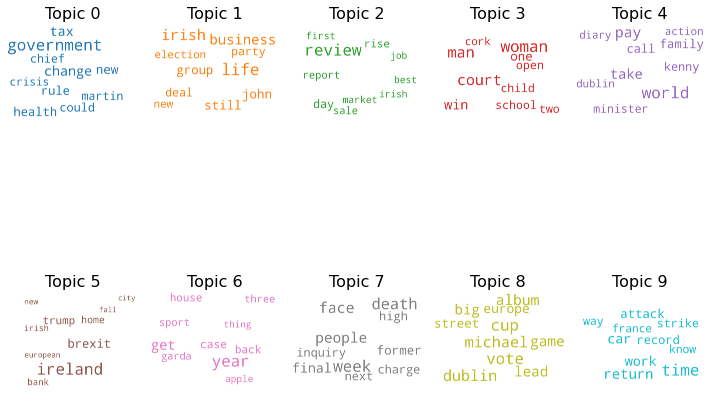

In [19]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = ireland_lda.show_topics(formatted=False)

fig, axes = plt.subplots(2, 5, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

Sources:

1) Notebook 12_Clustering_TopicModelling.ipynb
    
2) Manual filtering in LDA: https://stackoverflow.com/questions/49532089/how-to-remove-a-word-in-lda-analysis-by-gensim

3) PyLDAvis for LDA visualisation idea + code: https://towardsdatascience.com/lda-topic-modeling-with-tweets-deff37c0e131

4) WordCloud for LDA visualisation idea + code (lots of cool analysis tools!): https://www.machinelearningplus.com/nlp/topic-modeling-visualization-how-to-present-results-lda-models/

5) LDA vs Word2vec explanation: https://stats.stackexchange.com/questions/145485/lda-vs-word2vec

---

---